In [1]:
import numpy as np
import pandas as pd
import os
import sys

import matplotlib.pyplot as plt

# ensure the backend is set
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "torch"

import keras

# import keras
from keras.src.backend.common import global_state

global_state.set_global_attribute("torch_device", "cpu")
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"



In [2]:
%load_ext autoreload
%autoreload 2
import bayesflow as bf


In [3]:
species_to_keep = [
	# 'time',
	# blood species
	'Cent.Teff_1_0',
	'Cent.Treg',
	'Cent.nT_CD4',
	'Cent.nT_CD8',
	'Cent.Nivo',
	# lymph node species
	'LN.Nivo',
	'LN.APC',
	'LN.mAPC',
	'LN.nT_CD8',
	'LN.nT_CD4',
	'LN.Treg',
	'LN.aTreg_CD4',
	'LN.IL2',
	'LN.Cp',
	'LN.D1_0',
	'LN.aT_1_0',
	'LN.Teff_1_0',
	# tumor species
	'Tum.Nivo',
	'Tum.APC',
	'Tum.mAPC',
	'Tum.C1',
	'Tum.Cp',
	'Tum.Ckine_Mat',
	'Tum.Treg',
	'Tum.Teff_PD1',
	'Tum.D1_0',
	'Tum.Teff_1_0',
	'Tum.Teff_exhausted',
	'Tum.DAMP',
	'Tum.C1_PDL1',
	'Tum.C1_PDL2'
]

In [ ]:
# get all QSP_0.csv files from the experiments folder
exp_dir = '../qsp_experiments/hpc1_10k_pd1pdl1/outputs/subject_1'
num_samples = 5000
species_idx = range(17)
data_idx = list(range(num_samples))
qsp_paths = [os.path.join(exp_dir, 'qsp_arr_' + str(i + 1) + '.npz') for i in data_idx]

# def read_offline_data(obs_path, param_path, validation_ratio: float = 0.02):
observables = [np.load(path)['arr_0'] for path in qsp_paths]
observables = np.concatenate(observables, axis=0)
observables = observables[:,:,species_idx]

In [478]:
def observables_processor(obs):
	obs = obs[:,:,species_idx]

	sigma = 1e-2
	# epsilon = 1e-8
	noise = np.random.normal(0, sigma, obs.shape)
	# data = np.exp(np.log(observables + epsilon) + noise) - epsilon
	# data[data <= 0] = 1e-16
	# data = np.log(data)
	obs += noise

	thin = 4 * 7
	obs = obs[:,::thin,:]

	return obs

In [479]:
data = observables_processor(observables)

In [480]:
data.shape

(5000, 53, 17)

In [481]:
data.min()

-0.04826697598655602

In [482]:
scaled_sample = (data[50,:,:] / data[50,:,:].max(axis=0))

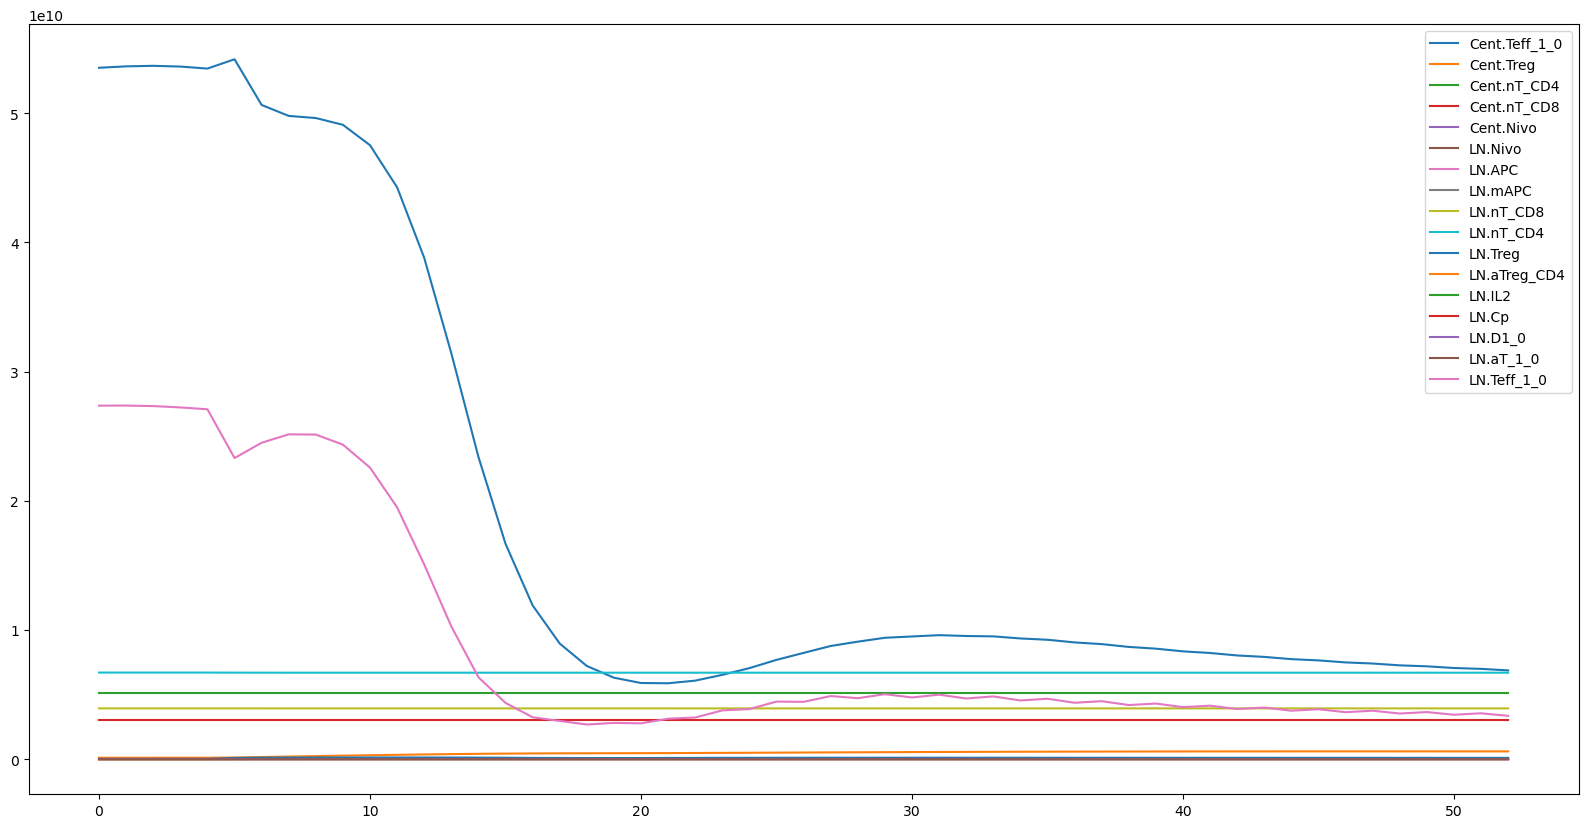

In [483]:
# plot one of the samples with all of the different species, scaled to the same range
plt.figure(figsize=(20, 10))
plt.plot(data[47,:,:])
plt.legend(species_to_keep)
# plt.yscale('log')  # Set y-axis to log scale
plt.show()

In [484]:
params_df = pd.read_csv(os.path.join(exp_dir,'param_log.csv'), index_col=0, header=0)

In [485]:
params = params_df.to_numpy()[data_idx]

In [486]:
params.shape

(5000, 1)

In [487]:
# keep_inliers = (params < 100).squeeze()
# params = params[keep_inliers]
# data = data[keep_inliers,:,:]

In [488]:
validation_ratio = 0.1
split = int(validation_ratio * params.shape[0])
train = {"kd": params[split:], 
					"sim_data": data[split:]}
validation = {"kd": params[:split], 
							"sim_data": data[:split]}   

In [489]:
train['sim_data'].min()

-0.04826697598655602

In [490]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .as_time_series("sim_data")
	# .constrain(["kd"],lower=0)
    .concatenate(["kd"], into="inference_variables")
    # .rename("prior_draws", "inference_variables")
    .rename("sim_data", "summary_variables")
    # since all our variables are non-negative (zero or larger)
    # this .apply call ensures that the variables are transformed
    # to the unconstrained real space and can be back-transformed under the hood
    .apply(forward=lambda x: np.log1p(x), inverse=lambda x: np.expm1(x))
	# .apply(include=["inference_variables"],forward=lambda x: np.log(x), inverse=lambda x: np.exp(x))
    .standardize()
)

In [491]:
adapted_sims = adapter(train)
print(adapted_sims["summary_variables"].shape)
print(adapted_sims["inference_variables"].shape)

(4500, 53, 17)
(4500, 1)


In [492]:
adapted_sims["summary_variables"].max()

5.179431

In [493]:
class GRU(bf.networks.SummaryNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.gru = keras.layers.GRU(64, dropout=0.1)
        self.summary_stats = keras.layers.Dense(8)
        
    def call(self, time_series, **kwargs):
        """Compresses time_series of shape (batch_size, T, 1) into summaries of shape (batch_size, 8)."""

        summary = self.gru(time_series, training=kwargs.get("stage") == "training")
        summary = self.summary_stats(summary)
        return summary

In [494]:
summary_net = GRU()

In [495]:
inference_net = bf.networks.FlowMatching(
    subnet_kwargs={"residual": True, "dropout": 0.1, "widths": (128, 128, 128)}
)

In [496]:
workflow = bf.BasicWorkflow(
    adapter=adapter,
    inference_network=inference_net,
    summary_network=summary_net,
    inference_variables=["kd"]
)

In [497]:
history = workflow.fit_offline(train, epochs=30, batch_size=32, validation_data=validation)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.6060 - loss/inference_loss: 0.6060 - val_loss: 0.0876 - val_loss/inference_loss: 0.0876
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.2293 - loss/inference_loss: 0.2293 - val_loss: 0.1901 - val_loss/inference_loss: 0.1901
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.1601 - loss/inference_loss: 0.1601 - val_loss: 0.1855 - val_loss/inference_loss: 0.1855
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.1531 - loss/inference_loss: 0.1531 - val_loss: 0.0795 - val_loss/inference_loss: 0.0795
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.1400 - loss/inference_loss: 0.1400 - val_loss: 0.0616 - val_loss/inference_loss: 0.0616
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.1185 - loss/inference_loss: 0.1185 - val_loss: 0.0793 - val_loss/inference_loss: 0.0793
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.1194 - loss/inference_loss: 0.1

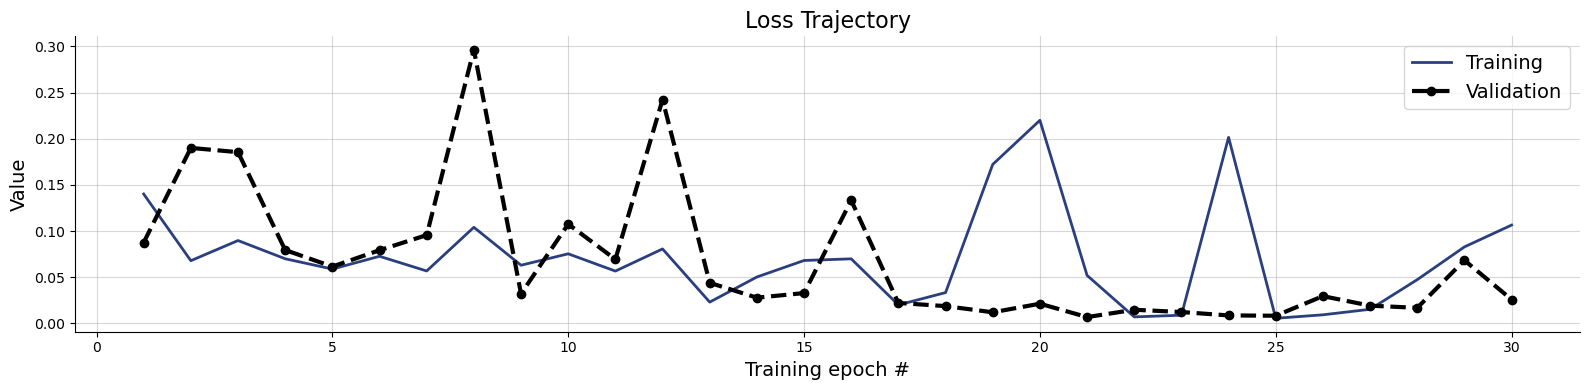

In [498]:
f = bf.diagnostics.plots.loss(history)

In [499]:
# # Set the number of posterior draws you want to get
# num_samples = 1000
num_test_samples = 500
test_idx = list(range(num_samples, num_samples + num_test_samples))
# test_idx = list(range(num_test_samples)) # CHANGE THIS BACK!!

test_qsp_paths = [os.path.join(exp_dir, 'qsp_arr_' + str(i + 1) + '.npz') for i in test_idx]


In [500]:

test_observables = [np.load(path)['arr_0'] for path in test_qsp_paths]
test_observables = np.concatenate(test_observables, axis=0)
test_observables = observables_processor(test_observables)
test_params = params_df.to_numpy()[test_idx]

test_sims = {"kd": test_params, 
					"sim_data": test_observables}


time_series = test_sims.pop("sim_data")
num_posterior_samples = 500
samples = workflow.sample(conditions={"sim_data": time_series}, num_samples=num_posterior_samples)

In [501]:
samples['kd'].shape

(500, 500, 1)

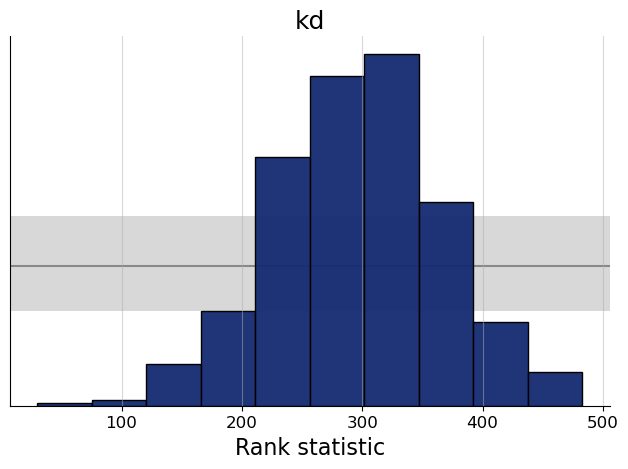

In [502]:
f = bf.diagnostics.plots.calibration_histogram(samples,test_sims)

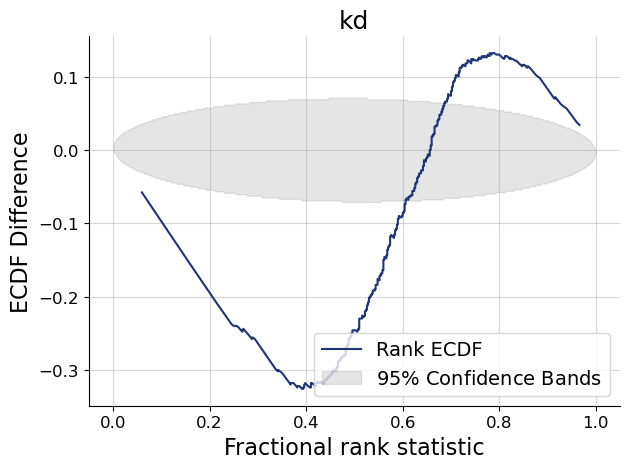

In [503]:
f = bf.diagnostics.plots.calibration_ecdf(samples, test_sims, difference=True)

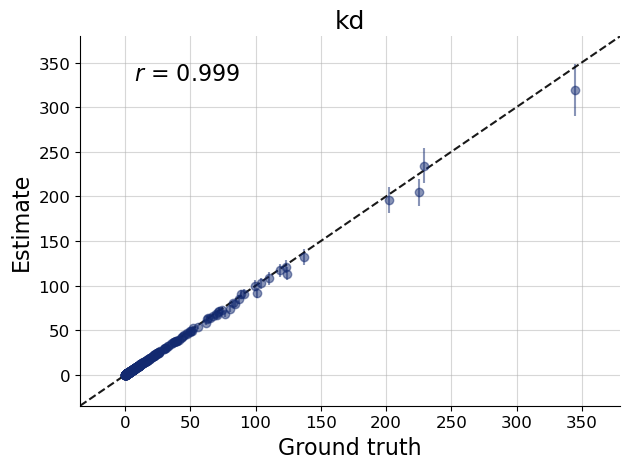

In [504]:
f = bf.diagnostics.plots.recovery(samples, test_sims)

(array([  27.,  112.,  415.,  912., 1301., 1176.,  688.,  282.,   76.,
          11.]),
 array([-2.8774427 , -1.9475632 , -1.0176837 , -0.0878042 ,  0.84207531,
         1.77195481,  2.70183431,  3.63171381,  4.56159331,  5.49147281,
         6.42135231]),
 <BarContainer object of 10 artists>)

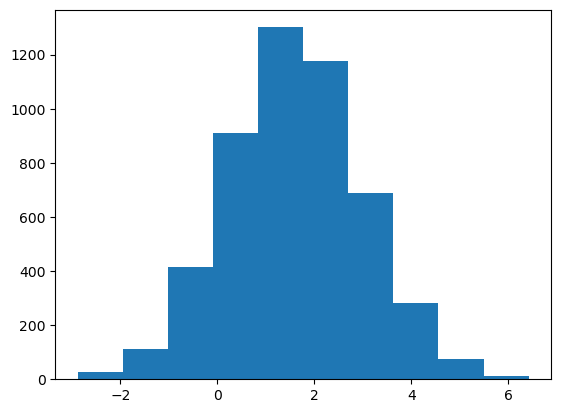

In [505]:
plt.hist(np.log(params))

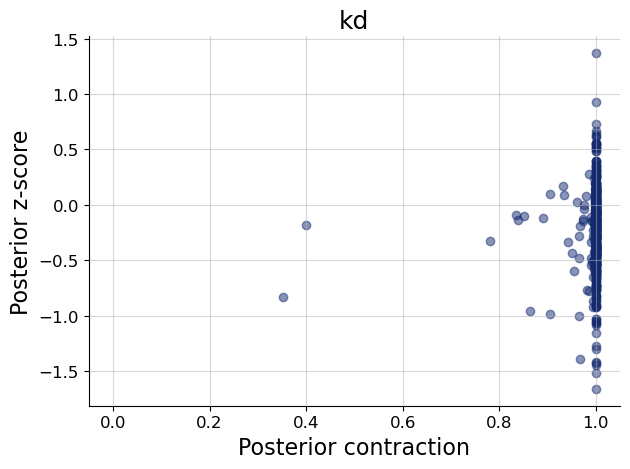

In [506]:
f = bf.diagnostics.plots.z_score_contraction(samples, test_sims)